# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu giá cà phê nội địa

Dữ liệu về giá cà phê được thu thập của tỉnh Đăk Lăk, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến nay.
*   date*: ngày
*   price: giá cà phê


In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe.csv', encoding='ISO-8859-1')
df_coffee.tail()

,date,price
6353,5/28/2024,116700.0
6354,5/29/2024,120700.0
6355,5/30/2024,122700.0
6356,5/31/2024,123500.0
6357,6/1/2024,120000.0


In [ ]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6358 non-null   object 
 1   price   6358 non-null   float64
dtypes: float64(1), object(1)
memory usage: 99.5+ KB


In [ ]:
df_coffee['date'] = pd.to_datetime(df_coffee['date'])
df_coffee.set_index('date', inplace=True)

### Điền dữ liệu ngày thiếu

In [ ]:
idx = pd.date_range(df_coffee.index.min(), df_coffee.index.max())
df_coffee = df_coffee.reindex(idx)
df_coffee.fillna(method='ffill', inplace=True)
df_coffee.tail()

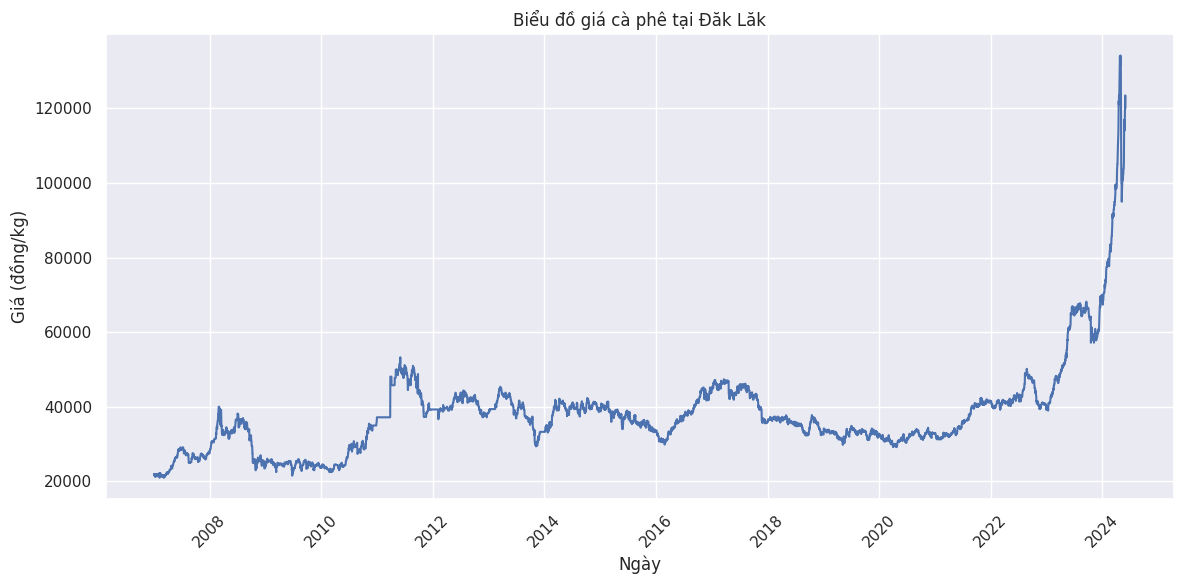

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Làm mịn dữ liệu

In [ ]:
df_coffee = df_coffee.rolling(window=30, min_periods=1).mean()

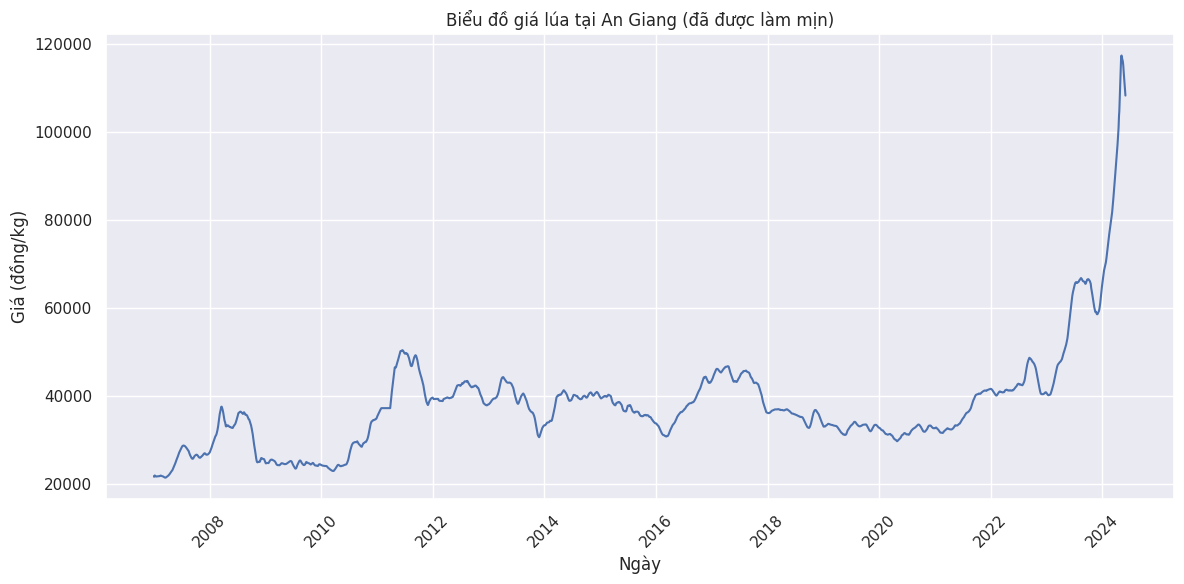

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk (đã được làm mịn)')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mô hình BiLSTM dự đoán đơn biến

Mạng Bidirectional Long Short-Term Memory (BiLSTM) là biến thể từ mạng LSTM, nó là sự kết hợp của hai lớp LSTM chạy song song ngược hướng trong cùng một chuỗi dữ liệu thời gian, một lớp LSTM chạy xuôi từ đầu đến cuối chuỗi dữ liệu và một lớp LSTM chạy ngược từ cuối về đầu chuỗi dữ liệu. Bởi vì mô hình BiLSTM xử lý thông tin cả hai hướng của chuỗi dữ liệu nên nó có thể hiểu được ngữ cảnh từ hai hướng, giúp tăng khả năng phân tích, xử lý.

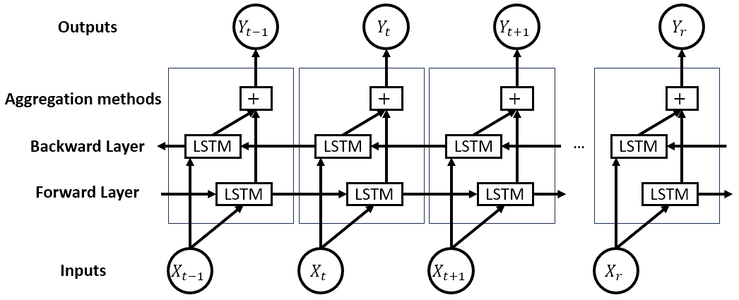

## Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(df_coffee['price'].values.reshape(-1, 1))

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_price, seq_length)

In [ ]:
X.shape, y.shape

((6328, 30, 1), (6328, 1))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (5062, 30, 1) (5062, 1)
Kích thước tập kiểm tra: (1266, 30, 1) (1266, 1)


In [ ]:
model = Sequential()
# model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Bidirectional(LSTM(units=128), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
80/80 [==============================] - 13s 105ms/step - loss: 0.0013
Epoch 2/50
80/80 [==============================] - 6s 81ms/step - loss: 1.0682e-04
Epoch 3/50
80/80 [==============================] - 8s 103ms/step - loss: 7.9887e-05
Epoch 4/50
80/80 [==============================] - 7s 84ms/step - loss: 6.0214e-05
Epoch 5/50
80/80 [==============================] - 8s 99ms/step - loss: 4.4933e-05
Epoch 6/50
80/80 [==============================] - 7s 90ms/step - loss: 3.3792e-05
Epoch 7/50
80/80 [==============================] - 7s 92ms/step - loss: 2.5378e-05
Epoch 8/50
80/80 [==============================] - 8s 100ms/step - loss: 2.3966e-05
Epoch 9/50
80/80 [==============================] - 7s 85ms/step - loss: 2.1357e-05
Epoch 10/50
80/80 [==============================] - 8s 104ms/step - loss: 1.6342e-05
Epoch 11/50
80/80 [==============================] - 6s 81ms/step - loss: 1.7386e-05
Epoch 12/50
80/80 [==============================] - 8s 103ms/step - loss

## Dự đoán tập train

In [ ]:
train_predictions = model.predict(X_train)

159/159 [==============================] - 4s 20ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 155.25
Training MAPE: 0.34%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình BiLSTM)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Dự đoán tập test

In [ ]:
test_predictions = model.predict(X_test)

40/40 [==============================] - 1s 21ms/step


In [ ]:
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {train_mape:.2f}%')

Testing RMSE: 565.21
Testing MAPE: 0.34%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình BiLSTM)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  155.25      0.34
1   Test  565.21      0.39


## Lưu mô hình



In [ ]:
model.save('BiLSTM_gia_cafe.h5')

NameError: name 'model' is not defined